In [1]:
# necessary packages
import numpy as np # for numerical operations
import matplotlib.pyplot as plt # for plotting
import jax # for faster numerical operations
import jax.numpy as jnp # for numpy-like syntax
from jax.scipy import stats
import numpyro # for inference and probabilistic programming
import arviz as az # for checking numpyro results (summary tables)
import tinygp  # for Gaussian process regression
from tinygp import GaussianProcess, kernels
import numpyro.distributions as dist
from tinygp import transforms

/home/edr76/.conda/envs/jax2/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# necessary for running on GPU
import os
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = 'false'
os.environ['CUDA_VISIBLE_DEVICES'] = '2'

In [3]:
# load data
data_dict = dict(np.load('poisson_data.npz')) 
x = data_dict['x'] # bin centers
x_bin = data_dict['x_bin'] # bin edges
log_y = data_dict['log_y'] # log of true rate
y = data_dict['y'] # true rate
y_obs = data_dict['y_obs'] # observed counts

# if you want to generate a different Poisson sample, use the following instead

# x_bin = np.linspace(0,1,20) # 10 random points between -1 and 1
# x = 0.5 * (x_bin[:-1] + x_bin[1:])
# log_rate = -2 * x**2. * np.abs(1 + np.cos(8. * x**(1.4)))
# y = 20 * np.exp(log_rate)
# y_obs = np.random.poisson(y) 

In [4]:
# Joint kernel for function-values f and derivatives df/dx

# Effectively, [f f'] ~ N(0, K)
# where K is the joint kernel matrix 
# K = [[K_ff K_fd], [K_df K_dd]]
# where K_ff is the kernel matrix for f

# Instead of concatenating f and f' to a larger array, we distinguish f and f' by 
# introducing a boolean variable d, which is 1 if we sample a derivative and 0 otherwise
# (ref: https://tinygp.readthedocs.io/en/latest/tutorials/derivative.html

class DerivativeKernel(kernels.Kernel):
    def __init__(self, kernel):
        self.kernel = kernel
    def evaluate(self, X1, X2):
        t1, d1 = X1
        print(t1.shape)
        t2, d2 = X2
        # Differentiate the kernel function: the first derivative wrt x1
        Kp = jax.grad(self.kernel.evaluate, argnums=0)
        # ... and the second derivative
        Kpp = jax.grad(Kp, argnums=1)
        # Evaluate the kernel matrix and all of its relevant derivatives
        K = self.kernel.evaluate(t1, t2)
        d2K_dx1dx2 = Kpp(t1, t2)
        # For stationary kernels, these are related just by a minus sign, but we'll
        # evaluate them both separately for generality's sake
        dK_dx2 = jax.grad(self.kernel.evaluate, argnums=1)(t1, t2)
        dK_dx1 = Kp(t1, t2)
        return jnp.where(
            d1, jnp.where(d2, d2K_dx1dx2, dK_dx1), jnp.where(d2, dK_dx2, K)
        )

In [5]:
# SVI fit to 1D Poisson data with Gaussian Process prior
# on log_rate and its derivatives, subject to derivative-regularization

# NOTE: UNLIKE THE APPROACH IN 1d_poisson_svi.ipynb, THIS APPROACH 
# LOADS FUNCTIONS AND DERIVATIVES SEPARATELY BY USING THE MARGINAL GP
# FOR THE FUNCTIONS AND USING THE SAMPLED FUNCTIONS TO SAMPLE DERIVATIVES
# FROM THE CONDITIONAL GP.  

def model(x, y=None):
    Nx = x.shape[0]
    # define parameters of Gaussian Process prior on log_rate (zero mean and Matern52 kernel)
    sigma = numpyro.param(
        "sigma", jnp.ones(()), constraint=dist.constraints.positive
    )
    rho = numpyro.param(
        "rho", 2. * jnp.ones(()), constraint=dist.constraints.positive
    )

    # Set up the augmented input consisting of position and boolean for derivative
    x2 = jnp.concatenate([x,x])
    d2 = jnp.concatenate([jnp.zeros_like(x),jnp.ones_like(x)])
    x_aug = jnp.vstack([x2.T,d2.T]).T

    # load joint kernel from the original function kernel
    base_kernel = sigma**2 * kernels.Matern52(rho)
    kernel = DerivativeKernel(base_kernel)
    gp = GaussianProcess(kernel, x_aug[:Nx], diag=1e-3) 

    # sample log_rate from GP
    log_rate = numpyro.sample("log_rate", gp.numpyro_dist())

    # define the likelihood
    rate = jnp.exp(log_rate)
    numpyro.sample("obs", dist.Poisson(rate), obs=y) # can't use numpyro.factor for svi

    # sample log_rate_deriv from GP conditioned on log_rate
    _, gp_cond = gp.condition(log_rate, x_aug[Nx:]) # condition GP on log_rate and sample derivatives at x_aug[Nx:]
    log_rate_p = gp_cond.sample(jax.random.PRNGKey(5573)) # log_rate_deriv
    rate = jnp.exp(log_rate) 
    rate_p = rate * log_rate_p # rate_deriv
    numpyro.factor("constraint", -10. * jnp.float32(jnp.sum(jnp.where(rate_p > 0, rate_p, 0.))))

# guide of posterior distribution of log_rate and log_rate_deriv
def guide(x, y=None):
    mu = numpyro.param(
        "log_rate_mu", jnp.zeros((x.shape[0],))
    )
    sigma = numpyro.param(
        "log_rate_sigma",
        jnp.ones((x.shape[0],)),
        constraint=dist.constraints.positive,
    )

    numpyro.sample("log_rate", dist.Independent(dist.Normal(mu, sigma), 1))

# run SVI
optim = numpyro.optim.Adam(0.01)
svi = numpyro.infer.SVI(model, guide, optim, numpyro.infer.Trace_ELBO(10))
results = svi.run(jax.random.PRNGKey(5573), 10000, x, y=y_obs, progress_bar=True)

()
()
()
()
()
()
()


  0%|          | 0/10000 [00:00<?, ?it/s]

()
()
()
()
()
()
()


100%|██████████| 10000/10000 [00:11<00:00, 866.21it/s, init loss: 8581.6504, avg. loss [9501-10000]: 70.3305]


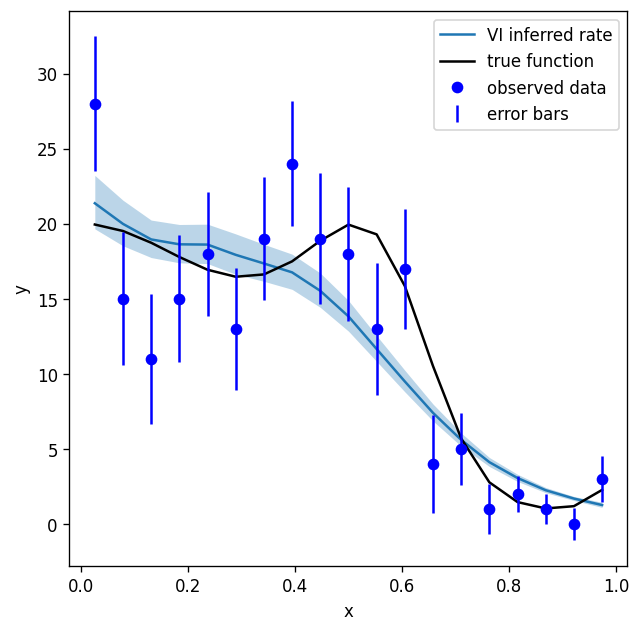

In [6]:
# plot posterior of rate and rate_deriv

fig = plt.figure(figsize=(6, 6), dpi= 120)
ax1 = fig.add_subplot(111)

Nx = len(x) # number of datapoints

# ------------------------------
# ax1: plot posterior of log_rate

# load optimal guide parameters for log_rate (f)
mu = results.params["log_rate_mu"]
sigma = results.params["log_rate_sigma"]

# plot guide (posterior approximation)
ax1.plot(x, np.exp(mu), color="C0", label="VI inferred rate")
ax1.fill_between(
    x,
    np.exp(mu - 2 * sigma),
    np.exp(mu + 2 * sigma),
    alpha=0.3,
    lw=0,
    color="C0",
)

# plot data with crude error bars 
ax1.plot(x, y, 'k', label='true function')
ax1.plot(x, y_obs, 'bo', label='observed data')
ax1.errorbar(x, y_obs, yerr = np.sqrt(y), c = 'b', fmt = 'none', label='error bars')
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.legend()

()
()
(500,)


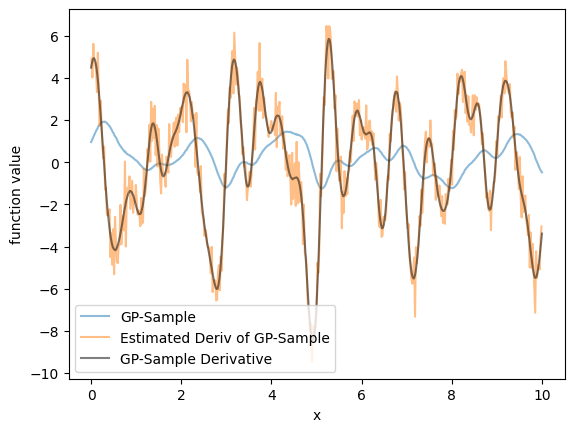

In [9]:
# Verification that sampling derivatives from conditional distribution works

# sample function and derivative from joint GP
dt = np.linspace(0, 10, 500)
# Set up the kernel and GP objects
x2 = jnp.concatenate([dt,dt])
d2 = jnp.concatenate([jnp.zeros_like(dt),jnp.ones_like(dt)])
x_aug = jnp.vstack([x2.T,d2.T]).T

base_kernel = 1. * kernels.ExpSquared(scale=0.25)
kernel = DerivativeKernel(base_kernel)
gp = GaussianProcess(kernel, x_aug, diag = 1e-4)

# plot sample of function and derivative from gp

output = gp.sample(jax.random.PRNGKey(9), shape = (1,))

f = output[0,:500]
df = output[0,500:]
print(f.shape)
plt.plot(dt,f, label = 'GP-Sample', alpha = 0.5)
plt.plot(0.5 * (dt[1:] + dt[:-1]), jnp.diff(f) / jnp.diff(dt), label = 'Estimated Deriv of GP-Sample', alpha = 0.5)
plt.plot(dt,df, c = 'k', alpha = 0.5, label = 'GP-Sample Derivative')
plt.xlabel('x')
plt.ylabel('function value')
plt.legend()

()
()
()
()
()
()
()
(500,)


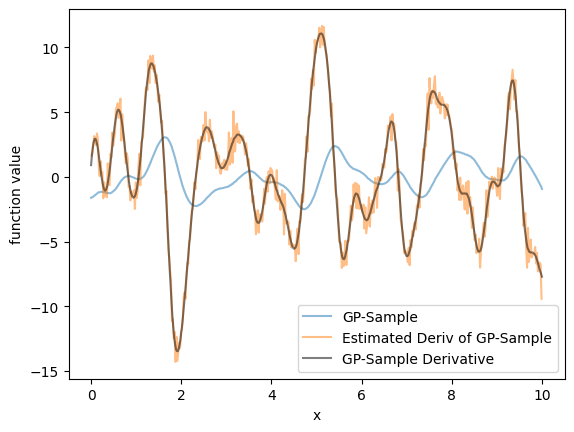

In [11]:
# sample function from marginal GP and sample derivatives from conditional GP
x_aug_f = x_aug[:500]
gp = GaussianProcess(kernel, x_aug_f, diag = 1e-4)

x_aug_p = x_aug[500:]
_, gp_cond = gp.condition(output, x_aug[500:])

# plot sample of function and derivative from both GPs
output = gp.sample(jax.random.PRNGKey(9))
output_p = gp_cond.sample(jax.random.PRNGKey(9))

f = output
df = output_p
print(f.shape)
plt.plot(dt,f, label = 'GP-Sample', alpha = 0.5)
plt.plot(0.5 * (dt[1:] + dt[:-1]), jnp.diff(f) / jnp.diff(dt), label = 'Estimated Deriv of GP-Sample', alpha = 0.5)
plt.plot(dt,df, c = 'k', alpha = 0.5, label = 'GP-Sample Derivative')
plt.xlabel('x')
plt.ylabel('function value')
plt.legend()

In [ ]:
def cartesian_to_polar_(x,y):
    r = jnp.sqrt(x**2. + y**2.)
    theta = jnp.arctan2(y,x)
    return jnp.array([r,theta]).T

def Wendland_C2(t, tau, c):
    # tau >= 4
    T = t/c
    return (1. + tau * T) * jnp.power(1.-T, tau)

class AngularDistance(kernels.stationary.Distance):
    def distance(self, theta1, theta2):
        return jnp.arccos(jnp.cos(theta1 - theta2))
        
class GeodesicKernel(kernels.Kernel):
    def __init__(self, tau):
        self.tau = tau
        self.distance = AngularDistance()
    
    def evaluate(self, theta1, theta2):
        angular_distance = self.distance.distance(theta1, theta2)
        return Wendland_C2(angular_distance, self.tau, jnp.pi)    
    
class PolarKernel(kernels.Kernel):
    def __init__(self, kernel_r, kernel_ang, sigma, alpha1, alpha2):
        self.kernel_r = kernel_r
        self.kernel_ang = kernel_ang
        
        self.sigma = sigma
        self.alpha1 = alpha1
        self.alpha2 = alpha2
    
    def evaluate(self,X1,X2):
        rho1, theta1 = X1
        rho2, theta2 = X2
        
        return (self.sigma * 
                (1. + self.alpha1 * self.kernel_r.evaluate(rho1,rho2)) * 
                (1. + self.alpha2 * self.kernel_ang.evaluate(theta1,theta2)))

class DerivativePolarKernel(kernels.Kernel):
    def __init__(self, kernel_r, kernel_ang, sigma, alpha1, alpha2):
        self.kernel_r = kernel_r
        self.kernel_ang = kernel_ang
        
        self.sigma = sigma
        self.alpha1 = alpha1
        self.alpha2 = alpha2
    
    def evaluate(self,X1,X2):
        rho1, theta1, d1 = X1
        rho2, theta2, d2 = X2
        
        # Differentiate the kernel function: the first derivative wrt x1
        Kp = jax.grad(self.kernel_r.evaluate, argnums=0)
        # ... and the second derivative
        Kpp = jax.grad(Kp, argnums=1)
        # Evaluate the kernel matrix and all of its relevant derivatives
        K = self.kernel_r.evaluate(rho1, rho2)
        d2K_dx1dx2 = Kpp(rho1, rho2)
        # For stationary kernels, these are related just by a minus sign, but we'll
        # evaluate them both separately for generality's sake
        dK_dx2 = jax.grad(self.kernel_r.evaluate, argnums=1)(rho1, rho2)
        dK_dx1 = Kp(rho1, rho2)
        
        return ( self.sigma * (
                jnp.where(
                    d1, jnp.where(d2, self.alpha1 * d2K_dx1dx2, self.alpha1 * dK_dx1), 
                    jnp.where(d2, self.alpha1 * dK_dx2, 1. + self.alpha1 * K)
            ) )
                * (1. + self.alpha2 * self.kernel_ang.evaluate(theta1,theta2) )
               )